# Machine Failure Predictions

In [129]:
import pyspark as ps
import csv
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [130]:
spark = (ps.sql.SparkSession.builder
        .master("local[4]")
        .appName("morning sprint")
        .getOrCreate()
        )

sc = spark.sparkContext

In [362]:
df = spark.read.csv('sample.csv', header=True)

In [363]:
df.count()

32

In [365]:
train_df = spark.read.csv('train.csv', header=True)

In [366]:
train_df.show(n=3)

+---+----------------+-----------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+----------------------------+-------+----------+-----------+------------------+-----------------+----------+------------+------------+
| ID|            Date|Temperature|Humidity| Operator|Measure1|Measure2|Measure3|Measure4|Measure5|Measure6|Measure7|Measure8|Measure9|Measure10|Measure11|Measure12|Measure13|Measure14|Measure15|Hours Since Previous Failure|Failure|?Date.year|?Date.month|?Date.day-of-month|?Date.day-of-week|?Date.hour|?Date.minute|?Date.second|
+---+----------------+-----------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+----------------------------+-------+----------+-----------+------------------+-----------------+----------+------------+------------+
|  1|01-01-20

In [367]:
train_df = train_df.drop('?Date.minute', '?Date.second')

In [369]:
train_df.describe().show()

+-------+------------------+----------------+------------------+-----------------+---------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+----------------------------+-------+----------+------------------+------------------+------------------+-----------------+
|summary|                ID|            Date|       Temperature|         Humidity| Operator|          Measure1|          Measure2|          Measure3|          Measure4|         Measure5|          Measure6|          Measure7|         Measure8|         Measure9|        Measure10|         Measure11|         Measure12|         Measure13|        Measure14|        Measure15|Hours Since Previous Failure|Failure|?Date.year|       ?Date.month|?Date.day-of-month| ?Date.day-of-week|       ?Date.hour|
+-------+-

In [374]:
train_df.dtypes

[('ID', 'string'),
 ('Date', 'string'),
 ('Temperature', 'string'),
 ('Humidity', 'string'),
 ('Operator', 'string'),
 ('Measure1', 'string'),
 ('Measure2', 'string'),
 ('Measure3', 'string'),
 ('Measure4', 'string'),
 ('Measure5', 'string'),
 ('Measure6', 'string'),
 ('Measure7', 'string'),
 ('Measure8', 'string'),
 ('Measure9', 'string'),
 ('Measure10', 'string'),
 ('Measure11', 'string'),
 ('Measure12', 'string'),
 ('Measure13', 'string'),
 ('Measure14', 'string'),
 ('Measure15', 'string'),
 ('Hours Since Previous Failure', 'string'),
 ('Failure', 'string'),
 ('?Date.year', 'string'),
 ('?Date.month', 'string'),
 ('?Date.day-of-month', 'string'),
 ('?Date.day-of-week', 'string'),
 ('?Date.hour', 'string')]

In [375]:
from functools import reduce
dates = ['year', 'month', 'day_of_month', 'day_of_week', 'hour']
columns = train_df.columns[:-5] + dates


oldColumns = train_df.schema.names
newColumns = columns

df = reduce(lambda train_df, idx: train_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), train_df)
df.printSchema()
df.show()

root
 |-- ID: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Humidity: string (nullable = true)
 |-- Operator: string (nullable = true)
 |-- Measure1: string (nullable = true)
 |-- Measure2: string (nullable = true)
 |-- Measure3: string (nullable = true)
 |-- Measure4: string (nullable = true)
 |-- Measure5: string (nullable = true)
 |-- Measure6: string (nullable = true)
 |-- Measure7: string (nullable = true)
 |-- Measure8: string (nullable = true)
 |-- Measure9: string (nullable = true)
 |-- Measure10: string (nullable = true)
 |-- Measure11: string (nullable = true)
 |-- Measure12: string (nullable = true)
 |-- Measure13: string (nullable = true)
 |-- Measure14: string (nullable = true)
 |-- Measure15: string (nullable = true)
 |-- Hours Since Previous Failure: string (nullable = true)
 |-- Failure: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_month: strin

In [376]:
from pyspark.sql.functions import col
to_int = df.columns[2:4] + df.columns[5:21] + df.columns[22:]

df = df.select(*(col(c).cast("int").alias(c) if c in to_int else col(c) for c in df.columns))

In [377]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Temperature: integer (nullable = true)
 |-- Humidity: integer (nullable = true)
 |-- Operator: string (nullable = true)
 |-- Measure1: integer (nullable = true)
 |-- Measure2: integer (nullable = true)
 |-- Measure3: integer (nullable = true)
 |-- Measure4: integer (nullable = true)
 |-- Measure5: integer (nullable = true)
 |-- Measure6: integer (nullable = true)
 |-- Measure7: integer (nullable = true)
 |-- Measure8: integer (nullable = true)
 |-- Measure9: integer (nullable = true)
 |-- Measure10: integer (nullable = true)
 |-- Measure11: integer (nullable = true)
 |-- Measure12: integer (nullable = true)
 |-- Measure13: integer (nullable = true)
 |-- Measure14: integer (nullable = true)
 |-- Measure15: integer (nullable = true)
 |-- Hours Since Previous Failure: integer (nullable = true)
 |-- Failure: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |--

In [408]:
df.show(5)

+---+----------------+-----------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+----------------------------+-------+----+-----+------------+-----------+----+
| ID|            Date|Temperature|Humidity| Operator|Measure1|Measure2|Measure3|Measure4|Measure5|Measure6|Measure7|Measure8|Measure9|Measure10|Measure11|Measure12|Measure13|Measure14|Measure15|Hours Since Previous Failure|Failure|year|month|day_of_month|day_of_week|hour|
+---+----------------+-----------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+----------------------------+-------+----+-----+------------+-----------+----+
|  1|01-01-2016 00:00|         67|      82|Operator1|     291|       1|       1|    1041|     846|     334|     706|    1086|     256|     1295|      766|      968|     1185|     13

## Prepping data for random forest

In [409]:
features = df.select('*').toPandas()

In [410]:
## one hot encode 'Failure', 'Operator'
operators = pd.get_dummies(features['Operator'])
fail = pd.get_dummies(features['Failure'])

In [411]:
for oper in operators.columns:
    features[oper] = operators[oper]

In [412]:
features = features.drop(['Operator', 'Date', 'ID'], axis=1)
features['Failure'] = fail

In [413]:
# Saving feature names for later use
feature_list = list(features.columns)

In [414]:
features.head()

,Temperature,Humidity,Measure1,Measure2,Measure3,Measure4,Measure5,Measure6,Measure7,Measure8,...,day_of_week,hour,Operator1,Operator2,Operator3,Operator4,Operator5,Operator6,Operator7,Operator8
0,67,82,291,1,1,1041,846,334,706,1086,...,5,0,1,0,0,0,0,0,0,0
1,68,77,1180,1,1,1915,1194,637,1093,524,...,5,1,1,0,0,0,0,0,0,0
2,64,76,1406,1,1,511,1577,1121,1948,1882,...,5,2,1,0,0,0,0,0,0,0
3,63,80,550,1,1,1754,1834,1413,1151,945,...,5,3,1,0,0,0,0,0,0,0
4,65,81,1928,1,2,1326,1082,233,1441,1736,...,5,4,1,0,0,0,0,0,0,0


In [415]:
labels = np.array(features.pop('Failure'))

# Split data into testing and training sets

In [416]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [417]:
## Encode labels
encoder = LabelEncoder()
labels = encoder.fit_transform(np.array(labels))
labels

array([1, 1, 1, ..., 1, 1, 1])

In [491]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)

## I don't have access to the labels for the real training set so we'll need to do one more tts

In [492]:
Training_Set = [X_test, y_test]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.33)

### We'll train on X_train, validate on x_val, test on x_test

In [493]:
print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('y_train shape: ', y_train.shape)
print('y_val shape: ', y_val.shape)

X_train shape:  (3971, 31)
X_val shape:  (1957, 31)
y_train shape:  (3971,)
y_val shape:  (1957,)


# Begin Random Forest

In [494]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix


In [495]:
rf = RandomForestClassifier(n_estimators=500, 
                            criterion='entropy', 
                            random_state=42,
                            class_weight="balanced"
                           )

In [496]:
ss = StandardScaler(copy=True)
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)

In [497]:
print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('y_train shape: ', y_train.shape)
print('y_val shape: ', y_val.shape)

X_train shape:  (3971, 31)
X_val shape:  (1957, 31)
y_train shape:  (3971,)
y_val shape:  (1957,)


In [498]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=500, random_state=42)

In [499]:
y_pred = rf.predict(X_val)
y_pred.shape, X_val.shape, y_val.shape

((1957,), (1957, 31), (1957,))

In [500]:
cm = confusion_matrix(y_val, y_pred)
cm

array([[  12,    9],
       [   0, 1936]])

In [501]:
f1_score(y_val, y_pred)

0.9976810100489565

## Testing

In [502]:
X_test = Training_Set[0]
y_test = Training_Set[1]

In [503]:
X_test = ss.transform(X_test)

In [504]:
predictions = rf.predict(X_test)

In [505]:
cm_test = confusion_matrix(y_test, predictions)
cm

array([[  12,    9],
       [   0, 1936]])

In [506]:
f1_score(y_test, predictions)

0.9982201881515382

# Let's try a NN

In [508]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
losses = []
model = Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### What's the failure rate right after the machine fails?

In [143]:
hour_after = df_2[df_2['Hours Since Previous Failure'] == 1]
## failure rate
hour_after[hour_after['Failure'] == 'Yes'].count() / hour_after.count()

0.6133333333333333

So once the machine fails it has a 61.3% chance of failing again.

This makes me think that the operators could be at fault

### Let's get a feel for what hours of the day the machines were running


In [144]:
df_2.groupBy("hour").count().sort("hour").show(24)


+----+-----+
|hour|count|
+----+-----+
|   0|  330|
|   1|  330|
|   2|  330|
|   3|  330|
|   4|  330|
|   5|  330|
|   6|  330|
|   7|  330|
|   8|  330|
|   9|  329|
|  10|  329|
|  11|  329|
|  12|  329|
|  13|  329|
|  14|  329|
|  15|  329|
|  16|  329|
|  17|  329|
|  18|  329|
|  19|  329|
|  20|  329|
|  21|  329|
|  22|  329|
|  23|  329|
+----+-----+



### What hours of the day did the machines fail?

In [145]:
failure_df = df_2.filter(df_2['Failure'] == 'Yes')

In [146]:
failure_df.count()

75

In [147]:
fail_by_hour = failure_df.groupBy("hour").count().sort("hour")
fail_by_hour.show(25)


+----+-----+
|hour|count|
+----+-----+
|   0|    4|
|   1|    3|
|   2|    6|
|   3|    2|
|   4|    5|
|   5|    5|
|   6|    8|
|   7|    5|
|   8|    3|
|   9|    4|
|  10|    3|
|  11|    3|
|  12|    5|
|  13|    3|
|  14|    1|
|  15|    3|
|  16|    1|
|  17|    3|
|  18|    1|
|  19|    1|
|  20|    1|
|  21|    1|
|  22|    2|
|  23|    2|
+----+-----+



In [148]:
fail_by_hour = fail_by_hour.select('*').toPandas()

Text(0.5, 1.0, 'Number of Failures at Each Operational Hour of the Day')

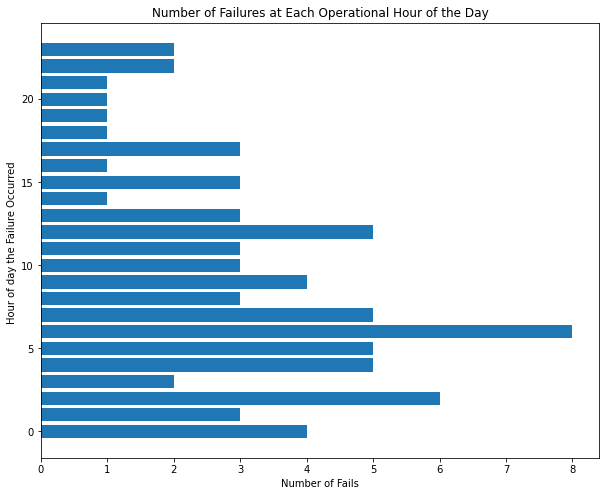

In [149]:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(fail_by_hour['hour'], fail_by_hour['count'])
ax.set_xlabel('Number of Fails')
ax.set_ylabel('Hour of day the Failure Occurred ')
ax.set_title('Number of Failures at Each Operational Hour of the Day')

### Maybe the person working the morning shift is slacking?

In [150]:
df_2['Operator', 'Failure', 'hour'].groupby('Operator', 'hour').count().sort('Operator', 'hour').show(100)

+---------+----+-----+
| Operator|hour|count|
+---------+----+-----+
|Operator1|   0|  110|
|Operator1|   1|  110|
|Operator1|   2|  110|
|Operator1|   3|  110|
|Operator1|   4|  110|
|Operator1|   5|  110|
|Operator1|   6|  110|
|Operator1|   7|  110|
|Operator2|   0|  110|
|Operator2|   1|  110|
|Operator2|   2|  110|
|Operator2|   3|  110|
|Operator2|   4|  110|
|Operator2|   5|  110|
|Operator2|   6|  110|
|Operator2|   7|  110|
|Operator2|   8|  110|
|Operator2|   9|  109|
|Operator2|  10|  109|
|Operator2|  11|  109|
|Operator2|  12|  109|
|Operator2|  13|  109|
|Operator2|  14|  109|
|Operator2|  15|  109|
|Operator3|   8|  110|
|Operator3|   9|  110|
|Operator3|  10|  110|
|Operator3|  11|  110|
|Operator3|  12|  110|
|Operator3|  13|  110|
|Operator3|  14|  110|
|Operator3|  15|  110|
|Operator4|   8|  110|
|Operator4|   9|  110|
|Operator4|  10|  110|
|Operator4|  11|  110|
|Operator4|  12|  110|
|Operator4|  13|  110|
|Operator4|  14|  110|
|Operator4|  15|  110|
|Operator5|

Operators 1, 2, 7 all work mornings. Let's check out operator failure rate

In [151]:
# Convert the Spark DataFrame back to a Pandas DataFrame using Arrow
operators_df = test_df.select("Operator", 'Failure').toPandas()
operators_df.head()

,Operator,Failure
0,Operator1,No
1,Operator1,No
2,Operator1,No
3,Operator1,No
4,Operator1,No


Text(0.5, 1.0, 'Failure Rate per Operator')

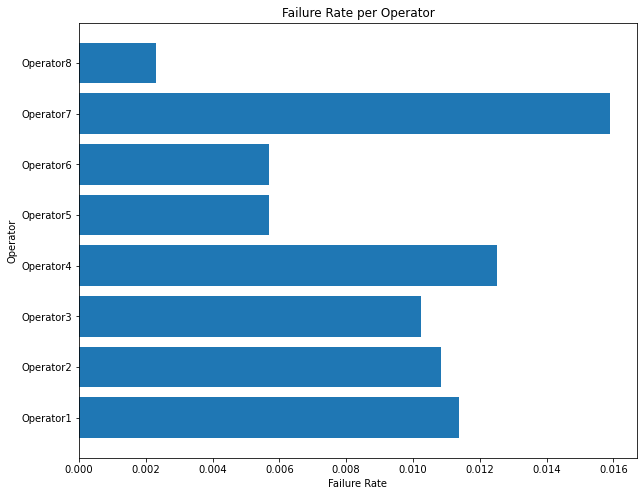

In [152]:
operators_df[operators_df['Failure'] == 'Yes']
op_fail_df = operators_df.groupby('Operator').agg('count')
op_fail_df['num'] = operators_df[operators_df['Failure'] == 'Yes'].groupby('Operator').agg('count')
op_fail_df['fail_rate'] = op_fail_df['num'] / op_fail_df['Failure']
op_fail_df
# operators_df.head()

fig, ax = plt.subplots(figsize=(10,8))
ax.barh(op_fail_df.index, op_fail_df['fail_rate'])
ax.set_xlabel('Failure Rate')
ax.set_ylabel('Operator')
ax.set_title('Failure Rate per Operator')

Let's check out failures / day of the week for fun

In [153]:
failure_df.groupBy("day_of_week").count().sort("day_of_week").show()


+-----------+-----+
|day_of_week|count|
+-----------+-----+
|          1|   11|
|          2|    8|
|          3|    6|
|          4|   14|
|          5|    6|
|          6|   10|
|          7|   20|
+-----------+-----+



## Begin Random Forest

In [345]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix


### Predict

In [351]:
accuracy_score(y_test, predictions)

0.981284774911482

## Testing

In [353]:
test_df = spark.read.csv('test.csv', header=True)
test_df = test_df.drop('?Date.minute', '?Date.second')
df.show(5)

+----+----------------+-----------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+----------------------------+----------+-----------+------------------+-----------------+----------+------------+------------+
|  ID|            Date|Temperature|Humidity| Operator|Measure1|Measure2|Measure3|Measure4|Measure5|Measure6|Measure7|Measure8|Measure9|Measure10|Measure11|Measure12|Measure13|Measure14|Measure15|Hours Since Previous Failure|?Date.year|?Date.month|?Date.day-of-month|?Date.day-of-week|?Date.hour|?Date.minute|?Date.second|
+----+----------------+-----------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+----------------------------+----------+-----------+------------------+-----------------+----------+------------+------------+
|7906|25-11-2016 09:00|         62

In [354]:
test_df = test_df.drop('?Date.minute', '?Date.second')
dates = ['year', 'month', 'day_of_month', 'day_of_week', 'hour']
columns = test_df.columns[:-5] + dates


oldColumns = test_df.schema.names
newColumns = columns

test_df = reduce(lambda test_df, idx: test_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), test_df)
test_df.printSchema()
test_df.show()

root
 |-- ID: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Humidity: string (nullable = true)
 |-- Operator: string (nullable = true)
 |-- Measure1: string (nullable = true)
 |-- Measure2: string (nullable = true)
 |-- Measure3: string (nullable = true)
 |-- Measure4: string (nullable = true)
 |-- Measure5: string (nullable = true)
 |-- Measure6: string (nullable = true)
 |-- Measure7: string (nullable = true)
 |-- Measure8: string (nullable = true)
 |-- Measure9: string (nullable = true)
 |-- Measure10: string (nullable = true)
 |-- Measure11: string (nullable = true)
 |-- Measure12: string (nullable = true)
 |-- Measure13: string (nullable = true)
 |-- Measure14: string (nullable = true)
 |-- Measure15: string (nullable = true)
 |-- Hours Since Previous Failure: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_month: string (nullable = true)
 |-- day_of_week: s

In [355]:
to_int = test_df.columns[2:4] + test_df.columns[5:21] + test_df.columns[22:]

test_df = test_df.select(*(col(c).cast("int").alias(c) if c in to_int else col(c) for c in test_df.columns))

In [357]:
test_df.show(5)
test_df.printSchema()

+----+----------------+-----------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+----------------------------+----+-----+------------+-----------+----+
|  ID|            Date|Temperature|Humidity| Operator|Measure1|Measure2|Measure3|Measure4|Measure5|Measure6|Measure7|Measure8|Measure9|Measure10|Measure11|Measure12|Measure13|Measure14|Measure15|Hours Since Previous Failure|year|month|day_of_month|day_of_week|hour|
+----+----------------+-----------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+----------------------------+----+-----+------------+-----------+----+
|7906|25-11-2016 09:00|         62|      85|Operator2|     573|       0|       2|    1122|     361|    1695|    1210|     984|    1056|      381|      823|      819|      527|     1837|     1988|       

In [358]:
features_test = test_df.select('*').toPandas()

In [364]:
features_test.count()

ID                              879
Date                            879
Temperature                     879
Humidity                        879
Operator                        879
Measure1                        879
Measure2                        879
Measure3                        879
Measure4                        879
Measure5                        879
Measure6                        879
Measure7                        879
Measure8                        879
Measure9                        879
Measure10                       879
Measure11                       879
Measure12                       879
Measure13                       879
Measure14                       879
Measure15                       879
Hours Since Previous Failure    879
year                            879
month                           879
day_of_month                    879
day_of_week                     879
hour                            879
dtype: int64

In [359]:
operators = pd.get_dummies(features_test['Operator'])
fail = pd.get_dummies(features_test['Failure'])

KeyError: 'Failure'

In [ ]:
for oper in operators.columns:
    features[oper] = operators[oper]
    
features = features.drop(['Operator', 'Date', 'ID'], axis=1)
features['Failure'] = fail

In [195]:
test_df_pd = test_df.select('*').toPandas()

In [197]:
failure_df[failure_df['?Date.day-of-month'] > 9].head()

,ID,Date,Temperature,Humidity,Operator,Measure1,Measure2,Measure3,Measure4,Measure5,...,Measure15,Hours Since Previous Failure,Failure,?Date.year,?Date.month,?Date.day-of-month,?Date.day-of-week,?Date.hour,?Date.minute,?Date.second
515,516,22-01-2016 11:00,71,65,Operator3,576,0,0,1074,1568,...,1821,367,Yes,2016,1,22,5,11,0,0
516,517,22-01-2016 12:00,72,67,Operator3,935,3,0,1228,1226,...,452,1,Yes,2016,1,22,5,12,0,0
517,518,22-01-2016 13:00,70,68,Operator3,1479,0,1,738,1686,...,1566,1,Yes,2016,1,22,5,13,0,0
667,668,28-01-2016 19:00,66,81,Operator5,1484,2,2,1174,1362,...,953,150,Yes,2016,1,28,4,19,0,0
1038,1039,13-02-2016 06:00,65,82,Operator2,1912,2,1,1343,1852,...,1914,371,Yes,2016,2,13,6,6,0,0


In [208]:
test_df

DataFrame[ID: string, Date: string, Temperature: string, Humidity: string, Operator: string, Measure1: string, Measure2: string, Measure3: string, Measure4: string, Measure5: string, Measure6: string, Measure7: string, Measure8: string, Measure9: string, Measure10: string, Measure11: string, Measure12: string, Measure13: string, Measure14: string, Measure15: string, Hours Since Previous Failure: string, Failure: string, ?Date.year: string, ?Date.month: string, ?Date.day-of-month: string, ?Date.day-of-week: string, ?Date.hour: string, ?Date.minute: string, ?Date.second: string]

In [180]:
## change objects to ints
numerics = test_df_pd.drop(columns=['Date', 'Operator', 'Failure'])
numerics = numerics.apply(pd.to_numeric, errors='coerce')
test_df_pd[numerics.columns] = numerics
test_df_pd.head()
test_df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   ID                            7905 non-null   int64 
 1   Date                          7905 non-null   object
 2   Temperature                   7905 non-null   int64 
 3   Humidity                      7905 non-null   int64 
 4   Operator                      7905 non-null   object
 5   Measure1                      7905 non-null   int64 
 6   Measure2                      7905 non-null   int64 
 7   Measure3                      7905 non-null   int64 
 8   Measure4                      7905 non-null   int64 
 9   Measure5                      7905 non-null   int64 
 10  Measure6                      7905 non-null   int64 
 11  Measure7                      7905 non-null   int64 
 12  Measure8                      7905 non-null   int64 
 13  Measure9          

In [183]:
failure_df = test_df_pd[test_df_pd['Failure'] == 'Yes']
failure_df = failure_df.dropna(how='any')
failure_df.info()
# test_df_pd[test_df_pd['Failure'] == 'Yes'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 148 to 7514
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   ID                            75 non-null     int64 
 1   Date                          75 non-null     object
 2   Temperature                   75 non-null     int64 
 3   Humidity                      75 non-null     int64 
 4   Operator                      75 non-null     object
 5   Measure1                      75 non-null     int64 
 6   Measure2                      75 non-null     int64 
 7   Measure3                      75 non-null     int64 
 8   Measure4                      75 non-null     int64 
 9   Measure5                      75 non-null     int64 
 10  Measure6                      75 non-null     int64 
 11  Measure7                      75 non-null     int64 
 12  Measure8                      75 non-null     int64 
 13  Measure9          

## Scatter matrix to check out relationships

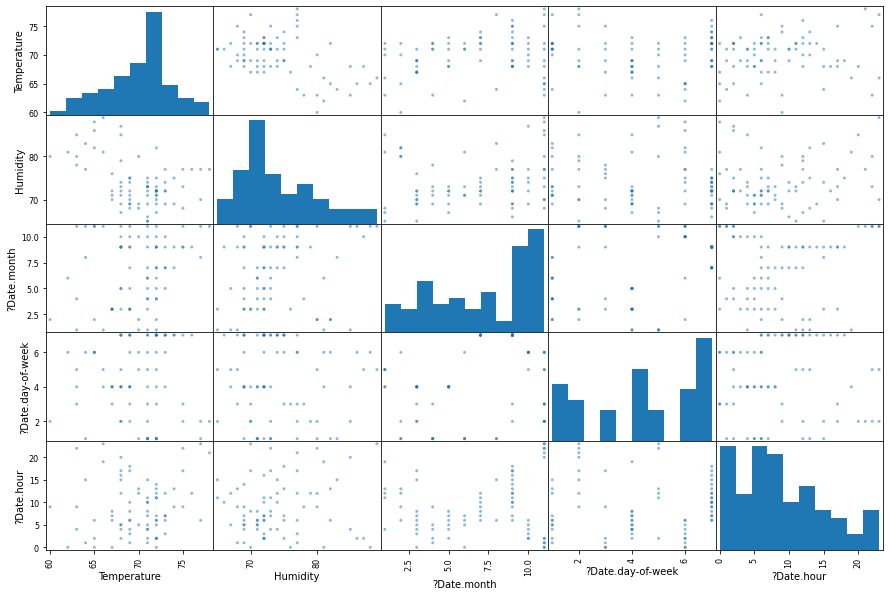

In [189]:
from matplotlib import gridspec

data_to_scatter = failure_df[['Temperature', 'Humidity', '?Date.month', '?Date.day-of-week', '?Date.hour']]
#'?Date.month', '?Date.day-of-week', '?Date.hour'
pd.plotting.scatter_matrix(data_to_scatter, alpha=0.5, figsize=(15,10))
plt.show();

Looking at the Date.hour/Date.day-of-the-week, it looks like failures are happening in distinct clusters of hours. 

Maybe a machine is more likely to fail it just previously failed?

### Let's check it out

In [178]:
failure_df[['Temperature', 'Humidity']][:5].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 148 to 667
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Temperature  5 non-null      object
 1   Humidity     5 non-null      object
dtypes: object(2)
memory usage: 120.0+ bytes


In [134]:
data_to_scatter.head()

,Temperature,Humidity,?Date.month,?Date.day-of-week,?Date.hour
148,63,85,1,4,4
515,71,65,1,5,11
516,72,67,1,5,12
517,70,68,1,5,13
667,66,81,1,4,19


In [140]:
data_to_scatter.head()

,Temperature,Humidity
148,63,85
515,71,65
516,72,67
517,70,68
667,66,81


## Let's check out how good these operators are

In [102]:
# Convert the Spark DataFrame back to a Pandas DataFrame using Arrow
operators_df = test_df.select("Operator", 'Failure').toPandas()
operators_df.head()

,Operator,Failure
0,Operator1,No
1,Operator1,No
2,Operator1,No
3,Operator1,No
4,Operator1,No


Text(0.5, 1.0, 'Failure Rate per Operator')

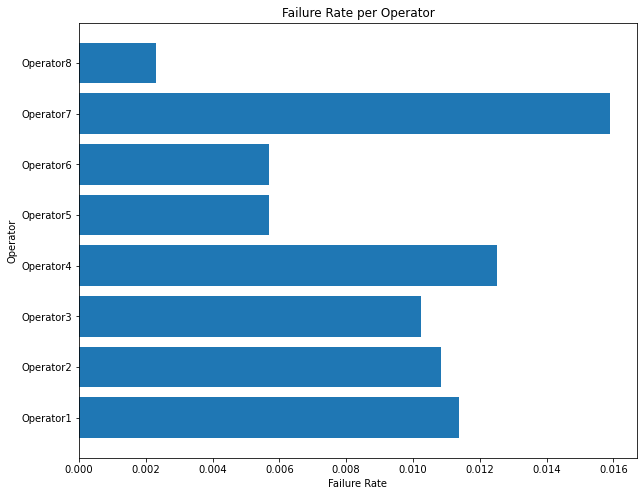

In [121]:
operators_df[operators_df['Failure'] == 'Yes']
op_fail_df = operators_df.groupby('Operator').agg('count')
op_fail_df['num'] = operators_df[operators_df['Failure'] == 'Yes'].groupby('Operator').agg('count')
op_fail_df['fail_rate'] = op_fail_df['num'] / op_fail_df['Failure']
op_fail_df
# operators_df.head()

fig, ax = plt.subplots(figsize=(10,8))
ax.barh(op_fail_df.index, op_fail_df['fail_rate'])
ax.set_xlabel('Failure Rate')
ax.set_ylabel('Operator')
ax.set_title('Failure Rate per Operator')

Text(0.5, 1.0, 'Failure Rate per Operator')

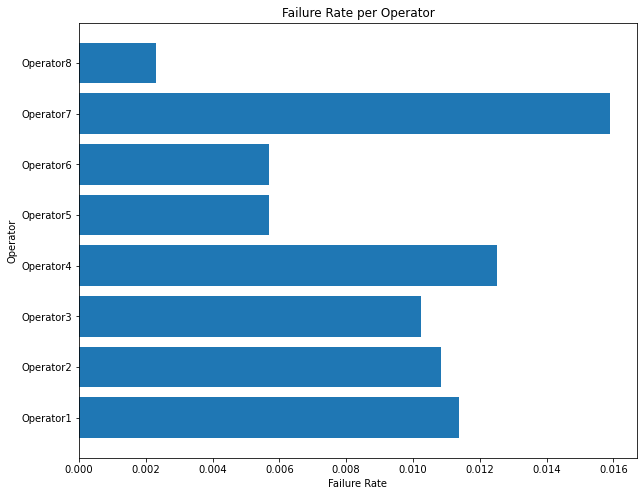

In [115]:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(op_fail_df.index, op_fail_df['fail_rate'])
ax.set_xlabel('Failure Rate')
ax.set_ylabel('Operator')
ax.set_title('Failure Rate per Operator')

In [60]:
operators_df[operators_df['Operator'] == 'Operator1'].count()

Operator    880
dtype: int64

In [ ]:
##